# Neural Networks Brain Surgery: Visualization of Financial Models
<div style="text-align: right">(C) Nikolai Nowaczyk, Jörg Kienitz, Sarp Kaya Acar, Qian Liang 2020</div>

Natural neural networks in the brains of financial engineers regard some financial models as more complex than others. For example, the Heston stochastic volatility model is regarded as more sophisticated than the plain-vanilla Black-Scholes model. But as how different do these model look like for an artificial neural network? We explore this question by training a neural network for each model under a comparable parameter set, compare their learning curves and visualize their trainable weights. We find that from a machine learning perspective, these models are actually not that different.

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras
import os
from ipywidgets import interact
import ipywidgets as wg
import json
import pickle
import unittest

from keras_grid import MLPGrid, LSTMGrid
from pricinglib import BlackScholesCallPrice, HestonCallPrice

%matplotlib notebook

# The Financial Models

## Black-Scholes Model

Let $(\Omega, \mathcal{F}, \mathbb{Q})$ be a probability space (where we think of $\mathbb{Q}$ as the risk-neutral measure). Then the Black-Scholes model assumes the following stochastic dynamics for the stock:
\begin{align}
dS_t = r S_t dt + \sigma S_t dW_t, \qquad S_0 = s_0
\end{align}
where
* $s_0$ is the initial value for the stock
* $r \in \mathbb{R}$ is a fixed *risk-free rate*, 
* $\sigma > 0$ is the *volatility*, 
and the process $W_t$ is a Brownian motion. 

In the Black-Scholes model, a European call option $C = C(T,K)$ with maturity $T>0$ and strike $K>0$ has market value 
\begin{align}
    C_t = \mathbb{E}_t[(S_T - K)^+] = S_t \Phi(d_1) - K \exp(-r (T-t)) \Phi(d_2),
\end{align}
where $\Phi$ denotes the cdf of the standard normal distribution and 
$$ d_1 := \frac{1}{\sqrt{T-t}} \Big( \log\Big( \frac{S_t}{K} \Big) + (r + \frac{\sigma^2}{2}) (t-T) \Big), \quad
d_2 := d_1 - \sigma \sqrt{T-t}$$

## Heston Model
The Heston model assumes the following stochastic dynamics:
\begin{align}
    dS_t &= rS_t dt + \sqrt(V_t)dW_t, \quad S_0 = s_0 \\
    dV_t &= \kappa(\theta - V_t) S_t dt + \xi \sqrt{V_t} dZ_t, && V_0 = v_0,
\end{align}
where
* $s_0$ is the initial value for the stock,
* $v_0$ is the initial value for the volatility,
* $r$ is the risk-free rate,
* $\kappa$ is the mean reversion rate of the volatility,
* $\xi$ is the volatility of the volatility
* $\rho$ is the assumed correlation between the Brownian motions $W_t$ and $Z_t$.

One typically assumes that the parameters are chosen such that the Feller condition holds: $2 \kappa \theta > \xi^2$.

The option price in a Heston model can be computed (for $t=0$) via 
\begin{align}
    C_0(T,K) = S_0 + \Pi_1 - e^{-rT} K \Pi_2,
\end{align}
where $\Pi_1$ and $\Pi_2$ are given as integrals over the characteristic function $\Psi = \Psi_{\ln(S_T)}$ of $\ln(S_T)$:
\begin{align}
    \Pi_1 &= \frac{1}{2} + \frac{1}{\pi}\int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w-i)}{i w \Psi(-i)} \Big) dw} \\
    \Pi_2 &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w)}{i w } \Big) dw}
\end{align}

## Observations

**1. Parameters:** The number of parameters is a key difference between these models, which is important for humans and machines alike. The Heston models has more parameters than the Black/Scholes model and it is clear that a network, wich has to learn the dependence of the option price on all of the Heston parameters needs to be set up differently than for Black-Scholes. Therefore, we restrict our attention only to learning the pricing function on a fixed grid of strikes and maturities $(K,T)$ with the other model parameters being fixed.

**2. Pricing Formula:** Even with fixed parameters, the option pricing formula in the Heston model is undoubtedly more difficult for humans as it involves solving indefinite integrals of complex functions. 

# Generating the Data Set

In [2]:
# parameter configuration
S0=100
T_max=1
maturity_grid = np.linspace(1/300, T_max, 300)
strike_grid = np.linspace(S0*0.8, S0*1.2, 400)
maturity_grid_, strike_grid_ = np.meshgrid(maturity_grid, strike_grid)
maturity_grid_ = maturity_grid_.ravel()
strike_grid_ = strike_grid_.ravel()

# heston model
v0 = 0.02
vLong = 0.04
kappa = 0.3
volvol = 0.4
rho = -0.6
q=0

# black scholes model
S = 100  # spot price
r = 0  # risk-free rate
sigma = np.sqrt(v0) # volatility

In [3]:
# generation of the data set
df = pd.DataFrame({'K': strike_grid_,
                   'T': maturity_grid_,
                   'C_BlackScholes': BlackScholesCallPrice(S0, r, sigma, maturity_grid_, strike_grid_, t=0)})
df['C_Heston'] = df.apply(lambda row: HestonCallPrice(S0, row['T'], row['K'], r, q, v0, vLong, kappa, sigma, rho), axis=1)

In [4]:
data_folder = os.path.join(os.getcwd(), 'data_surgery')
filename = 'df_prices_surgery.pkl'
df.to_pickle(os.path.join(data_folder, filename)) # save dataset to file

In [5]:
df = pd.read_pickle(os.path.join(data_folder, filename)) # load dataset from file

## Visualizing the Data Set

<IPython.core.display.Javascript object>


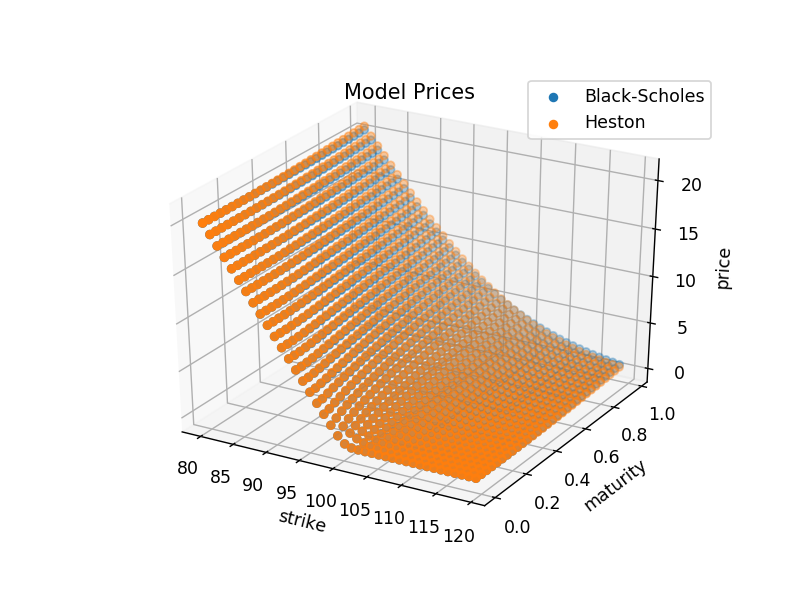

interactive(children=(SelectMultiple(description='Models', index=(0, 1), options=('BlackScholes', 'Heston'), v…

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# thinning out the df to avoid performance issues in the plot
df_3dplot = df[(df['T'].isin(maturity_grid[::10])) & (df['K'].isin(strike_grid[::10]))]


@interact(models=wg.SelectMultiple(
    options=['BlackScholes', 'Heston'],
    value=['BlackScholes', 'Heston'],
    description='Models',
))
def plot_dataset(models):
    ax.clear()
    if 'BlackScholes' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_BlackScholes'], label='Black-Scholes')
    if 'Heston' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_Heston'], label='Heston')
    ax.legend()
    ax.set_xlabel('strike')
    ax.set_ylabel('maturity')
    ax.set_zlabel('price')
    ax.set_title('Model Prices')

## Observation
While from a human point of view, computing prices in a Heston model is considerably more difficult than in the Black-Scholes model, the resulting data sets are structurally quite similar. 

# Setting up the Neural Networks

In [34]:
model_names = ['BlackScholes', 'Heston']
num_units = 128
np.random.seed(1)
models = {m: Sequential([Dense(units=num_units, input_shape=(2,), activation='sigmoid'),
                         Dense(units=num_units, input_shape=(2,), activation='sigmoid'),
                                Dense(units=1, activation='linear')]) for m in model_names}

## Training

In [35]:
compile_params = {
    'loss': 'mean_squared_error',
    'metrics': ['mean_squared_error', 'mean_absolute_error'],
    'optimizer': 'Adam',
}

for m in model_names:
    models[m].compile(**compile_params)

In [36]:
grid_spacing = 10
grid_offset = 5

df_train = df[(df['T'].isin(maturity_grid[::grid_spacing])) & (df['K'].isin(strike_grid[::grid_spacing]))]
df_cv = df[(df['T'].isin(maturity_grid[grid_offset::grid_spacing])) & (df['K'].isin(strike_grid[grid_offset::grid_spacing]))]

fit_params={
    'x': df_train[['K', 'T']],
    'epochs': 500,
    'shuffle': True}

In [37]:
history = {}
for m in model_names:
    history[m] = models[m].fit(y=df_train['C_' + m], 
                               validation_data=(df_cv[['K', 'T']], df_cv['C_' + m]), **fit_params)

Train on 1200 samples, validate on 1200 samples
Epoch 1/500
1200/1200 [==============================] - 0s 406us/step - loss: 54.6605 - mean_squared_error: 54.6605 - mean_absolute_error: 5.5144 - val_loss: 36.8593 - val_mean_squared_error: 36.8593 - val_mean_absolute_error: 5.1748
Epoch 2/500
1200/1200 [==============================] - 0s 57us/step - loss: 38.7460 - mean_squared_error: 38.7460 - mean_absolute_error: 5.3713 - val_loss: 36.5303 - val_mean_squared_error: 36.5303 - val_mean_absolute_error: 5.2837
Epoch 3/500
1200/1200 [==============================] - 0s 51us/step - loss: 38.1191 - mean_squared_error: 38.1191 - mean_absolute_error: 5.3418 - val_loss: 35.6264 - val_mean_squared_error: 35.6264 - val_mean_absolute_error: 5.1867
Epoch 4/500
1200/1200 [==============================] - 0s 75us/step - loss: 37.2805 - mean_squared_error: 37.2805 - mean_absolute_error: 5.2580 - val_loss: 34.6338 - val_mean_squared_error: 34.6338 - val_mean_absolute_error: 5.0890
Epoch 5/500
120

1200/1200 [==============================] - 0s 58us/step - loss: 1.1183 - mean_squared_error: 1.1183 - mean_absolute_error: 0.8492 - val_loss: 0.9692 - val_mean_squared_error: 0.9692 - val_mean_absolute_error: 0.7603
Epoch 37/500
1200/1200 [==============================] - 0s 63us/step - loss: 1.0604 - mean_squared_error: 1.0604 - mean_absolute_error: 0.8142 - val_loss: 0.9185 - val_mean_squared_error: 0.9185 - val_mean_absolute_error: 0.7942
Epoch 38/500
1200/1200 [==============================] - 0s 70us/step - loss: 1.0758 - mean_squared_error: 1.0758 - mean_absolute_error: 0.8310 - val_loss: 1.6597 - val_mean_squared_error: 1.6597 - val_mean_absolute_error: 1.0734
Epoch 39/500
1200/1200 [==============================] - 0s 72us/step - loss: 1.0338 - mean_squared_error: 1.0338 - mean_absolute_error: 0.8074 - val_loss: 0.9070 - val_mean_squared_error: 0.9070 - val_mean_absolute_error: 0.7215
Epoch 40/500
1200/1200 [==============================] - 0s 73us/step - loss: 0.9523 - m

1200/1200 [==============================] - 0s 56us/step - loss: 0.4919 - mean_squared_error: 0.4919 - mean_absolute_error: 0.5410 - val_loss: 0.4178 - val_mean_squared_error: 0.4178 - val_mean_absolute_error: 0.4864
Epoch 72/500
1200/1200 [==============================] - 0s 59us/step - loss: 0.4808 - mean_squared_error: 0.4808 - mean_absolute_error: 0.5360 - val_loss: 0.4900 - val_mean_squared_error: 0.4900 - val_mean_absolute_error: 0.5327
Epoch 73/500
1200/1200 [==============================] - 0s 59us/step - loss: 0.4875 - mean_squared_error: 0.4875 - mean_absolute_error: 0.5363 - val_loss: 0.4091 - val_mean_squared_error: 0.4091 - val_mean_absolute_error: 0.5044
Epoch 74/500
1200/1200 [==============================] - 0s 62us/step - loss: 0.4943 - mean_squared_error: 0.4943 - mean_absolute_error: 0.5423 - val_loss: 0.4067 - val_mean_squared_error: 0.4067 - val_mean_absolute_error: 0.4790
Epoch 75/500
1200/1200 [==============================] - 0s 53us/step - loss: 0.5036 - m

1200/1200 [==============================] - 0s 57us/step - loss: 0.4571 - mean_squared_error: 0.4571 - mean_absolute_error: 0.5253 - val_loss: 0.3556 - val_mean_squared_error: 0.3556 - val_mean_absolute_error: 0.4408
Epoch 107/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.3999 - mean_squared_error: 0.3999 - mean_absolute_error: 0.4843 - val_loss: 0.3714 - val_mean_squared_error: 0.3714 - val_mean_absolute_error: 0.4986
Epoch 108/500
1200/1200 [==============================] - 0s 63us/step - loss: 0.3950 - mean_squared_error: 0.3950 - mean_absolute_error: 0.4819 - val_loss: 0.3864 - val_mean_squared_error: 0.3864 - val_mean_absolute_error: 0.5123
Epoch 109/500
1200/1200 [==============================] - 0s 51us/step - loss: 0.4075 - mean_squared_error: 0.4075 - mean_absolute_error: 0.4852 - val_loss: 0.3889 - val_mean_squared_error: 0.3889 - val_mean_absolute_error: 0.4688
Epoch 110/500
1200/1200 [==============================] - 0s 49us/step - loss: 0.4168

1200/1200 [==============================] - 0s 58us/step - loss: 0.4559 - mean_squared_error: 0.4559 - mean_absolute_error: 0.5201 - val_loss: 0.6315 - val_mean_squared_error: 0.6315 - val_mean_absolute_error: 0.6895
Epoch 142/500
1200/1200 [==============================] - 0s 52us/step - loss: 0.4348 - mean_squared_error: 0.4348 - mean_absolute_error: 0.5119 - val_loss: 0.2593 - val_mean_squared_error: 0.2593 - val_mean_absolute_error: 0.3906
Epoch 143/500
1200/1200 [==============================] - 0s 53us/step - loss: 0.4655 - mean_squared_error: 0.4655 - mean_absolute_error: 0.5360 - val_loss: 0.2634 - val_mean_squared_error: 0.2634 - val_mean_absolute_error: 0.3653
Epoch 144/500
1200/1200 [==============================] - 0s 52us/step - loss: 0.4555 - mean_squared_error: 0.4555 - mean_absolute_error: 0.5300 - val_loss: 0.4378 - val_mean_squared_error: 0.4378 - val_mean_absolute_error: 0.5652
Epoch 145/500
1200/1200 [==============================] - 0s 50us/step - loss: 0.3127

1200/1200 [==============================] - 0s 50us/step - loss: 0.1746 - mean_squared_error: 0.1746 - mean_absolute_error: 0.2999 - val_loss: 0.2873 - val_mean_squared_error: 0.2873 - val_mean_absolute_error: 0.4044
Epoch 177/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.1745 - mean_squared_error: 0.1745 - mean_absolute_error: 0.2963 - val_loss: 0.1233 - val_mean_squared_error: 0.1233 - val_mean_absolute_error: 0.2660
Epoch 178/500
1200/1200 [==============================] - 0s 50us/step - loss: 0.1842 - mean_squared_error: 0.1842 - mean_absolute_error: 0.3125 - val_loss: 0.2068 - val_mean_squared_error: 0.2068 - val_mean_absolute_error: 0.3259
Epoch 179/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.1624 - mean_squared_error: 0.1624 - mean_absolute_error: 0.2875 - val_loss: 0.1534 - val_mean_squared_error: 0.1534 - val_mean_absolute_error: 0.3027
Epoch 180/500
1200/1200 [==============================] - 0s 51us/step - loss: 0.1428

1200/1200 [==============================] - 0s 55us/step - loss: 0.1781 - mean_squared_error: 0.1781 - mean_absolute_error: 0.3195 - val_loss: 0.1836 - val_mean_squared_error: 0.1836 - val_mean_absolute_error: 0.3587
Epoch 212/500
1200/1200 [==============================] - 0s 73us/step - loss: 0.1379 - mean_squared_error: 0.1379 - mean_absolute_error: 0.2786 - val_loss: 0.2943 - val_mean_squared_error: 0.2943 - val_mean_absolute_error: 0.4696
Epoch 213/500
1200/1200 [==============================] - 0s 68us/step - loss: 0.1574 - mean_squared_error: 0.1574 - mean_absolute_error: 0.2906 - val_loss: 0.0818 - val_mean_squared_error: 0.0818 - val_mean_absolute_error: 0.2238
Epoch 214/500
1200/1200 [==============================] - 0s 53us/step - loss: 0.0914 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2164 - val_loss: 0.0664 - val_mean_squared_error: 0.0664 - val_mean_absolute_error: 0.1684
Epoch 215/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.1046

1200/1200 [==============================] - 0s 55us/step - loss: 0.0657 - mean_squared_error: 0.0657 - mean_absolute_error: 0.1784 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1761
Epoch 247/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0654 - mean_squared_error: 0.0654 - mean_absolute_error: 0.1795 - val_loss: 0.0487 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1566
Epoch 248/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0715 - mean_squared_error: 0.0715 - mean_absolute_error: 0.1855 - val_loss: 0.1178 - val_mean_squared_error: 0.1178 - val_mean_absolute_error: 0.2797
Epoch 249/500
1200/1200 [==============================] - 0s 58us/step - loss: 0.0998 - mean_squared_error: 0.0998 - mean_absolute_error: 0.2365 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - val_mean_absolute_error: 0.1752
Epoch 250/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0760

1200/1200 [==============================] - 0s 107us/step - loss: 0.0588 - mean_squared_error: 0.0588 - mean_absolute_error: 0.1707 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1434
Epoch 282/500
1200/1200 [==============================] - 0s 129us/step - loss: 0.0542 - mean_squared_error: 0.0542 - mean_absolute_error: 0.1625 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1528
Epoch 283/500
1200/1200 [==============================] - 0s 95us/step - loss: 0.0597 - mean_squared_error: 0.0597 - mean_absolute_error: 0.1719 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1466
Epoch 284/500
1200/1200 [==============================] - 0s 117us/step - loss: 0.0510 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1584 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1348
Epoch 285/500
1200/1200 [==============================] - 0s 155us/step - loss: 0.

1200/1200 [==============================] - 0s 70us/step - loss: 0.0598 - mean_squared_error: 0.0598 - mean_absolute_error: 0.1744 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1177
Epoch 317/500
1200/1200 [==============================] - 0s 63us/step - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1423 - val_loss: 0.0805 - val_mean_squared_error: 0.0805 - val_mean_absolute_error: 0.2312
Epoch 318/500
1200/1200 [==============================] - 0s 65us/step - loss: 0.0700 - mean_squared_error: 0.0700 - mean_absolute_error: 0.1924 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1601
Epoch 319/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0465 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1525 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - val_mean_absolute_error: 0.2484
Epoch 320/500
1200/1200 [==============================] - 0s 68us/step - loss: 0.0563

1200/1200 [==============================] - 0s 61us/step - loss: 0.0692 - mean_squared_error: 0.0692 - mean_absolute_error: 0.1871 - val_loss: 0.1212 - val_mean_squared_error: 0.1212 - val_mean_absolute_error: 0.3007
Epoch 352/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.0914 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2318 - val_loss: 0.0696 - val_mean_squared_error: 0.0696 - val_mean_absolute_error: 0.2200
Epoch 353/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1307 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1161
Epoch 354/500
1200/1200 [==============================] - 0s 58us/step - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1439 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1195
Epoch 355/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.0516

1200/1200 [==============================] - 0s 66us/step - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1502 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1095
Epoch 387/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1360 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1672
Epoch 388/500
1200/1200 [==============================] - 0s 59us/step - loss: 0.0445 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1520 - val_loss: 0.0548 - val_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.1933
Epoch 389/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0426 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1425 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.0958
Epoch 390/500
1200/1200 [==============================] - 0s 47us/step - loss: 0.0440

1200/1200 [==============================] - 0s 69us/step - loss: 0.1135 - mean_squared_error: 0.1135 - mean_absolute_error: 0.2689 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 - val_mean_absolute_error: 0.2696
Epoch 422/500
1200/1200 [==============================] - 0s 53us/step - loss: 0.0586 - mean_squared_error: 0.0586 - mean_absolute_error: 0.1821 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1172
Epoch 423/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1229 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1421
Epoch 424/500
1200/1200 [==============================] - 0s 61us/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1840 - val_loss: 0.0840 - val_mean_squared_error: 0.0840 - val_mean_absolute_error: 0.2443
Epoch 425/500
1200/1200 [==============================] - 0s 50us/step - loss: 0.0602

1200/1200 [==============================] - 0s 64us/step - loss: 0.1531 - mean_squared_error: 0.1531 - mean_absolute_error: 0.3187 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1793
Epoch 457/500
1200/1200 [==============================] - 0s 57us/step - loss: 0.0560 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1776 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1577
Epoch 458/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1063 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1101
Epoch 459/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.1287 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1301
Epoch 460/500
1200/1200 [==============================] - 0s 58us/step - loss: 0.0258

1200/1200 [==============================] - 0s 58us/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1195 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1961
Epoch 492/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1317 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - val_mean_absolute_error: 0.2207
Epoch 493/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0298 - mean_squared_error: 0.0298 - mean_absolute_error: 0.1254 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1660
Epoch 494/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1240 - val_loss: 0.1311 - val_mean_squared_error: 0.1311 - val_mean_absolute_error: 0.3073
Epoch 495/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.1120

1200/1200 [==============================] - 0s 65us/step - loss: 1.4263 - mean_squared_error: 1.4263 - mean_absolute_error: 0.9669 - val_loss: 1.2624 - val_mean_squared_error: 1.2624 - val_mean_absolute_error: 0.9417
Epoch 27/500
1200/1200 [==============================] - 0s 51us/step - loss: 1.4768 - mean_squared_error: 1.4768 - mean_absolute_error: 0.9833 - val_loss: 1.2132 - val_mean_squared_error: 1.2132 - val_mean_absolute_error: 0.9253
Epoch 28/500
1200/1200 [==============================] - 0s 54us/step - loss: 1.3526 - mean_squared_error: 1.3526 - mean_absolute_error: 0.9325 - val_loss: 1.5437 - val_mean_squared_error: 1.5437 - val_mean_absolute_error: 0.9622
Epoch 29/500
1200/1200 [==============================] - 0s 55us/step - loss: 1.5366 - mean_squared_error: 1.5366 - mean_absolute_error: 0.9870 - val_loss: 1.2158 - val_mean_squared_error: 1.2158 - val_mean_absolute_error: 0.9362
Epoch 30/500
1200/1200 [==============================] - 0s 52us/step - loss: 1.1883 - m

1200/1200 [==============================] - 0s 51us/step - loss: 0.4527 - mean_squared_error: 0.4527 - mean_absolute_error: 0.5059 - val_loss: 0.4085 - val_mean_squared_error: 0.4085 - val_mean_absolute_error: 0.5047
Epoch 62/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.4337 - mean_squared_error: 0.4337 - mean_absolute_error: 0.4985 - val_loss: 0.4145 - val_mean_squared_error: 0.4145 - val_mean_absolute_error: 0.5164
Epoch 63/500
1200/1200 [==============================] - 0s 63us/step - loss: 0.4933 - mean_squared_error: 0.4933 - mean_absolute_error: 0.5435 - val_loss: 0.4121 - val_mean_squared_error: 0.4121 - val_mean_absolute_error: 0.5149
Epoch 64/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.5463 - mean_squared_error: 0.5463 - mean_absolute_error: 0.5741 - val_loss: 0.4124 - val_mean_squared_error: 0.4124 - val_mean_absolute_error: 0.4756
Epoch 65/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.5311 - m

1200/1200 [==============================] - 0s 67us/step - loss: 0.4561 - mean_squared_error: 0.4561 - mean_absolute_error: 0.5198 - val_loss: 0.4059 - val_mean_squared_error: 0.4059 - val_mean_absolute_error: 0.5351
Epoch 97/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.3660 - mean_squared_error: 0.3660 - mean_absolute_error: 0.4598 - val_loss: 0.3528 - val_mean_squared_error: 0.3528 - val_mean_absolute_error: 0.4392
Epoch 98/500
1200/1200 [==============================] - 0s 58us/step - loss: 0.3622 - mean_squared_error: 0.3622 - mean_absolute_error: 0.4613 - val_loss: 0.4442 - val_mean_squared_error: 0.4442 - val_mean_absolute_error: 0.5036
Epoch 99/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.4923 - mean_squared_error: 0.4923 - mean_absolute_error: 0.5478 - val_loss: 0.3500 - val_mean_squared_error: 0.3500 - val_mean_absolute_error: 0.4789
Epoch 100/500
1200/1200 [==============================] - 0s 57us/step - loss: 0.3518 - 

1200/1200 [==============================] - 0s 69us/step - loss: 0.3008 - mean_squared_error: 0.3008 - mean_absolute_error: 0.4149 - val_loss: 0.2723 - val_mean_squared_error: 0.2723 - val_mean_absolute_error: 0.4208
Epoch 132/500
1200/1200 [==============================] - 0s 62us/step - loss: 0.3216 - mean_squared_error: 0.3216 - mean_absolute_error: 0.4330 - val_loss: 0.2869 - val_mean_squared_error: 0.2869 - val_mean_absolute_error: 0.4379
Epoch 133/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.3081 - mean_squared_error: 0.3081 - mean_absolute_error: 0.4226 - val_loss: 0.2472 - val_mean_squared_error: 0.2472 - val_mean_absolute_error: 0.3788
Epoch 134/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.3059 - mean_squared_error: 0.3059 - mean_absolute_error: 0.4196 - val_loss: 0.2685 - val_mean_squared_error: 0.2685 - val_mean_absolute_error: 0.3749
Epoch 135/500
1200/1200 [==============================] - 0s 63us/step - loss: 0.3464

1200/1200 [==============================] - 0s 63us/step - loss: 0.2494 - mean_squared_error: 0.2494 - mean_absolute_error: 0.3683 - val_loss: 0.2126 - val_mean_squared_error: 0.2126 - val_mean_absolute_error: 0.3350
Epoch 167/500
1200/1200 [==============================] - 0s 58us/step - loss: 0.2261 - mean_squared_error: 0.2261 - mean_absolute_error: 0.3494 - val_loss: 0.2206 - val_mean_squared_error: 0.2206 - val_mean_absolute_error: 0.3888
Epoch 168/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.2557 - mean_squared_error: 0.2557 - mean_absolute_error: 0.3865 - val_loss: 0.1738 - val_mean_squared_error: 0.1738 - val_mean_absolute_error: 0.3083
Epoch 169/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.2026 - mean_squared_error: 0.2026 - mean_absolute_error: 0.3302 - val_loss: 0.1784 - val_mean_squared_error: 0.1784 - val_mean_absolute_error: 0.3320
Epoch 170/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.2089

1200/1200 [==============================] - 0s 71us/step - loss: 0.1275 - mean_squared_error: 0.1275 - mean_absolute_error: 0.2496 - val_loss: 0.0886 - val_mean_squared_error: 0.0886 - val_mean_absolute_error: 0.1971
Epoch 202/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.1386 - mean_squared_error: 0.1386 - mean_absolute_error: 0.2690 - val_loss: 0.1521 - val_mean_squared_error: 0.1521 - val_mean_absolute_error: 0.2776
Epoch 203/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.1017 - mean_squared_error: 0.1017 - mean_absolute_error: 0.2130 - val_loss: 0.0819 - val_mean_squared_error: 0.0819 - val_mean_absolute_error: 0.2089
Epoch 204/500
1200/1200 [==============================] - 0s 57us/step - loss: 0.1011 - mean_squared_error: 0.1011 - mean_absolute_error: 0.2146 - val_loss: 0.0838 - val_mean_squared_error: 0.0838 - val_mean_absolute_error: 0.2050
Epoch 205/500
1200/1200 [==============================] - 0s 52us/step - loss: 0.1050

1200/1200 [==============================] - 0s 62us/step - loss: 0.0630 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1714 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1463
Epoch 237/500
1200/1200 [==============================] - 0s 52us/step - loss: 0.0709 - mean_squared_error: 0.0709 - mean_absolute_error: 0.1904 - val_loss: 0.0485 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1512
Epoch 238/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_error: 0.1865 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1501
Epoch 239/500
1200/1200 [==============================] - 0s 58us/step - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.1510 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1412
Epoch 240/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0649

1200/1200 [==============================] - 0s 69us/step - loss: 0.1490 - mean_squared_error: 0.1490 - mean_absolute_error: 0.3005 - val_loss: 0.1418 - val_mean_squared_error: 0.1418 - val_mean_absolute_error: 0.3064
Epoch 272/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0705 - mean_squared_error: 0.0705 - mean_absolute_error: 0.1879 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1205
Epoch 273/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1421 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1545
Epoch 274/500
1200/1200 [==============================] - 0s 59us/step - loss: 0.0520 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1593 - val_loss: 0.0616 - val_mean_squared_error: 0.0616 - val_mean_absolute_error: 0.1966
Epoch 275/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.0477

1200/1200 [==============================] - 0s 56us/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1588 - val_loss: 0.0855 - val_mean_squared_error: 0.0855 - val_mean_absolute_error: 0.2350
Epoch 307/500
1200/1200 [==============================] - 0s 59us/step - loss: 0.0470 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1527 - val_loss: 0.0665 - val_mean_squared_error: 0.0665 - val_mean_absolute_error: 0.2070
Epoch 308/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1376 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1472
Epoch 309/500
1200/1200 [==============================] - 0s 51us/step - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1257 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1057
Epoch 310/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.0336

1200/1200 [==============================] - 0s 61us/step - loss: 0.0528 - mean_squared_error: 0.0528 - mean_absolute_error: 0.1611 - val_loss: 0.1416 - val_mean_squared_error: 0.1416 - val_mean_absolute_error: 0.3315
Epoch 342/500
1200/1200 [==============================] - 0s 53us/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1558 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1000
Epoch 343/500
1200/1200 [==============================] - 0s 52us/step - loss: 0.0529 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1669 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1155
Epoch 344/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0393 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1400 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1191
Epoch 345/500
1200/1200 [==============================] - 0s 68us/step - loss: 0.0441

1200/1200 [==============================] - 0s 54us/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1241 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1104
Epoch 377/500
1200/1200 [==============================] - 0s 65us/step - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1068 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0958
Epoch 378/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.0484 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1628 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1035
Epoch 379/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1011 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0866
Epoch 380/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0246

1200/1200 [==============================] - 0s 67us/step - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1321 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0971
Epoch 412/500
1200/1200 [==============================] - 0s 55us/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0862 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0913
Epoch 413/500
1200/1200 [==============================] - 0s 53us/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.0916 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0764
Epoch 414/500
1200/1200 [==============================] - 0s 56us/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1051 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0829
Epoch 415/500
1200/1200 [==============================] - 0s 64us/step - loss: 0.0197

1200/1200 [==============================] - 0s 65us/step - loss: 0.0483 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1714 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0784
Epoch 447/500
1200/1200 [==============================] - 0s 66us/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.0973 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1166
Epoch 448/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1063 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0905
Epoch 449/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1113 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0932
Epoch 450/500
1200/1200 [==============================] - 0s 54us/step - loss: 0.0188

1200/1200 [==============================] - 0s 57us/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0944 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1232
Epoch 482/500
1200/1200 [==============================] - 0s 67us/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0940 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0731
Epoch 483/500
1200/1200 [==============================] - 0s 59us/step - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1311 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1529
Epoch 484/500
1200/1200 [==============================] - 0s 59us/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1113 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1403
Epoch 485/500
1200/1200 [==============================] - 0s 62us/step - loss: 0.0288

## Learning Curves

<IPython.core.display.Javascript object>


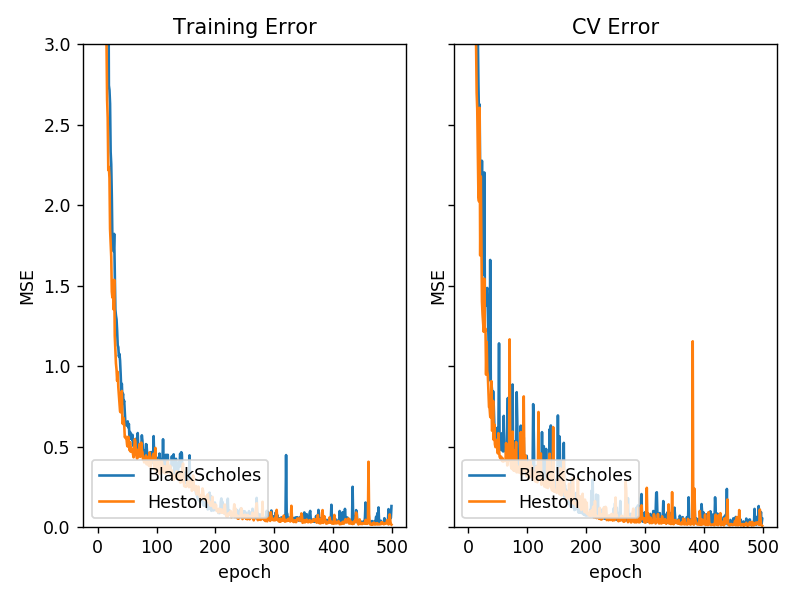

In [38]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)

axes[0].set_title('Training Error')
for i in range(2):
    axes[0].plot(history[model_names[i]].history['loss'], label=model_names[i])

axes[1].set_title('CV Error')
for i in range(2):
    axes[1].plot(history[model_names[i]].history['val_mean_squared_error'], label=model_names[i])

for i in range(2):
    axes[i].set_ylim([0,3])
    axes[i].set_xlabel('epoch')
    axes[i].set_ylabel('MSE')
    axes[i].legend(loc='lower left')
plt.tight_layout()

## Observation
The increased complexity of the Heston model does not make it more difficult for the network to learn the pricing function.

# Evaluating Neural Network Performance

In [39]:
for m in model_names:
    print(models[m].evaluate(x=df[['K', 'T']], y=df['C_' + m]))

120000/120000 [==============================] - 2s 16us/step
[0.05278826852241376, 0.05278826852241376, 0.19159618743509055]
120000/120000 [==============================] - 2s 15us/step
[0.00901395953915422, 0.00901395953915422, 0.06324837188199163]


In [40]:
res = {m : models[m].predict(df[['K', 'T']].values.astype(np.float32))[:,0] - df['C_' + m].values for m in model_names}

<IPython.core.display.Javascript object>


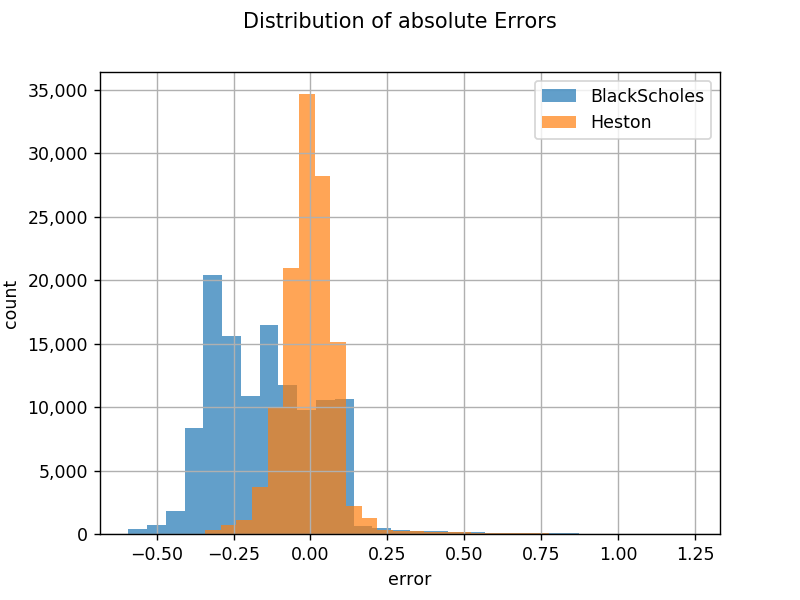

In [41]:
fig, ax = plt.subplots()

fig.suptitle('Distribution of absolute Errors')
for m in model_names:
    pd.Series(res[m]).hist(bins=30, label=m, alpha=0.7)
ax.legend()
ax.set_xlabel('error')
ax.set_ylabel('count')
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

**Observation:** The distribution of the absolute error over the entire data set (includes training, cross-validation is similar between the models.

# Brain Surgery
We plot the trained weights in the neural network from the Black-Scholes and the Heston model.

<IPython.core.display.Javascript object>


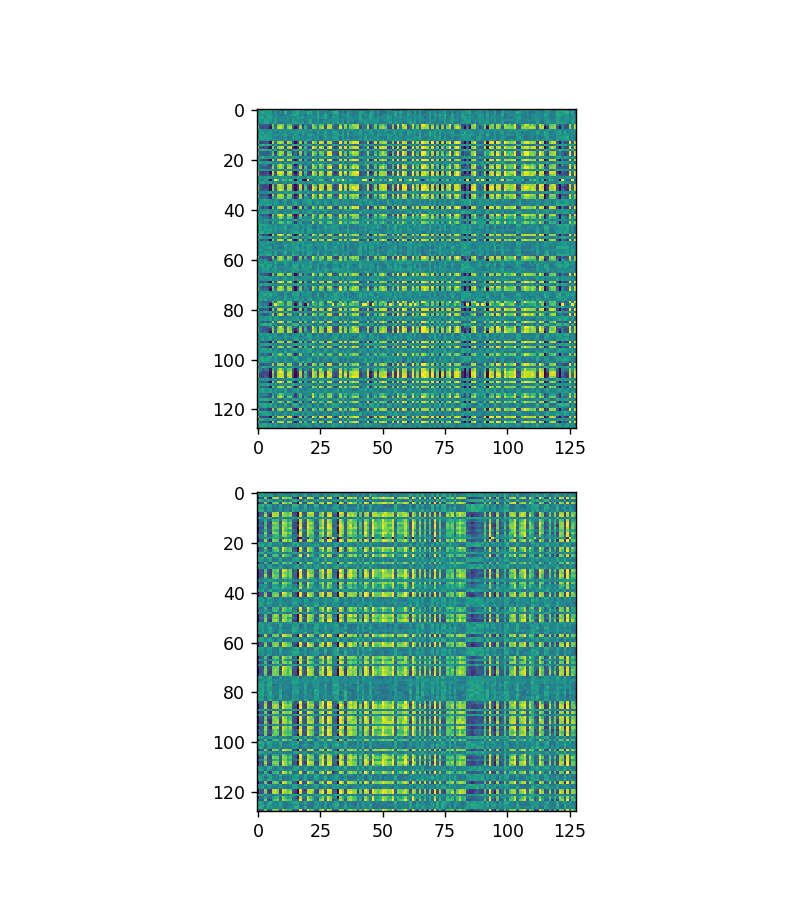

interactive(children=(IntSlider(value=0, description='layer_index', max=2), Dropdown(description='Weight Type:…

In [42]:
fig, ax = plt.subplots(2)
@interact(layer_index=wg.IntSlider(min=0, max=2, value=0),
          weight_type=wg.Dropdown(options=[('W',0), ('b',1)], value=0, description='Weight Type:'),
          vmin=wg.IntSlider(min=-10, max=-1, value=-5),
          vmax=wg.IntSlider(min=1, max=10, value=5))
def plot_weights_image(layer_index, weight_type, vmin, vmax):
    bs = models[model_names[0]].layers[layer_index].get_weights()[weight_type]
    heston = models[model_names[1]].layers[layer_index].get_weights()[weight_type]
    if weight_type==1:
        bs = bs[np.newaxis, :]
        heston = heston[np.newaxis, :]
    ax[0].imshow(bs, vmin=vmin, vmax=vmax)
    ax[1].imshow(heston, vmin=vmin, vmax=vmax)

<IPython.core.display.Javascript object>


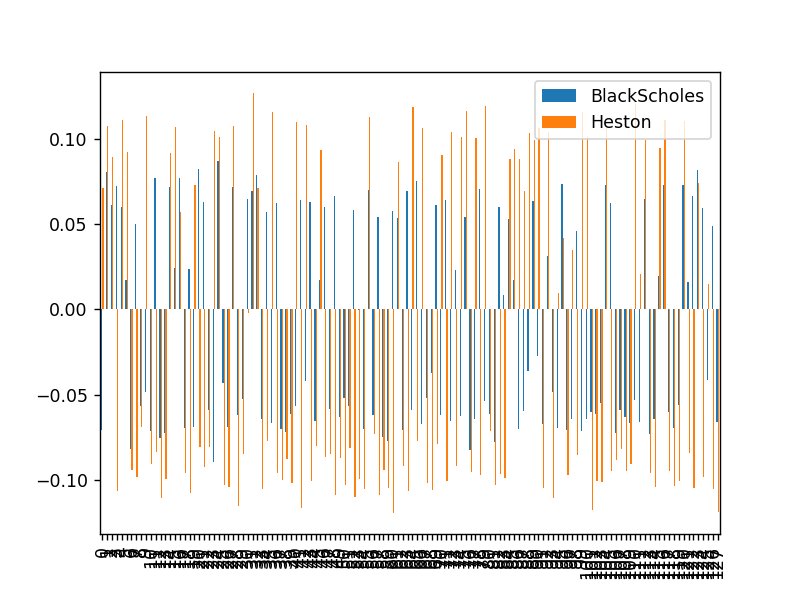

interactive(children=(IntSlider(value=0, description='layer_index', max=3), Dropdown(description='Weight Type:…

In [50]:
fig, ax = plt.subplots()

@interact(layer_index=wg.IntSlider(min=0, max=3, value=0),
          weight_type=wg.Dropdown(options=[('W', 0), ('b', 1)], value=0, description='Weight Type:'))
def plot_weights(layer_index, weight_type):
    ax.clear()    
    pd.DataFrame({model_names[0]: models[model_names[0]].layers[layer_index].get_weights()[weight_type].flatten(),
                  model_names[1]: models[model_names[1]].layers[layer_index].get_weights()[weight_type].flatten()}).plot.bar(ax=ax)
    #ax.set_ylim([-0.5, 0.5])